https://blog.csdn.net/u014264373/article/details/113701037
LoadImage和LoadImaged
* 普通变换又可以说是基于数组的变换：image和label是以数组形式给到Dataset。
* 字典变换是基于字典的变换（image和label是一个字典对)。

# LoadImage

MONAI的一个设计选择是，它不仅提供高级工作流组件，而且以最小的功能形式提供相对较低级别的api。

例如，LoadImage类是底层Nibabel映像加载器的简单可调用包装器。在使用一些必要的系统参数构造加载程序之后，使用NIfTI文件名调用加载程序实例将返回图像数据数组以及元数据，例如仿射信息和体素大小。简单说就是，如果是nii.gz格式的文件，调用LoadImage，它会自动调用Nibabel来打开数据。在python中，nii.gz一般都是通过Nibabel来打开的。

LoadImage/ LoadImaged在使用时会有细小的差别，通过举例来说明。

注意注意

如果这些变换不是在Compose里面进行组合使用，单独调用时都是需要先实例化的。

先把image和label的地址加载到data_dict中，便于后续做变换。

In [ ]:
import glob
from monai.transforms import LoadImage
import numpy as np
import matplotlib.pyplot as plt
data_dir = 'C:\\Users\\56991\\OneDrive\\PhD\\data\\Task09_Spleen'
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
# zip的意思是就是把image和label对应在dict里面，也就是变成了一个dict:
# {'image': '...', 'label': '...'}
train_data_dicts, val_data_dicts = data_dicts[:-9], data_dicts[-9:]
loader = LoadImage(dtype=np.float32)  # 实例化
image, metadata = loader(train_images[0]) # 把image的地址传给loader 也可以 train_data_dicts[0]["image"]

## 总结：
* train_images 所有Images的名称路径
* train_labels 所有labels的名称路径
* data_dicts 对应起来建立词典

LoadImage是会加载图像的值和元数据的。元数据里面包含分辨率，放射值，具体包含什么可以通过获取键来查询(metadata.keys())。
其中，最后一个”filename_or_obj“也是一个重要的信息，它是image的地址。

In [ ]:

print(len(train_images),'and',len(train_labels))
print(train_images[0])
print(data_dicts[0])
print(f"input image: {train_data_dicts[0]['image']}")
print(f"image shape: {image.shape}")
print(f"image affine:\n{metadata['affine']}")
print(f"image pixdim:\n{metadata['pixdim']}")
print(metadata.keys())
print(len(metadata.keys()))

# LoadImaged
这里的参数”keys“是你在data_dicts中设置的keys。表示要对image做变换还是label做变换。如果都做，就都写。比如keys=["image", "label"],  keys = 'image', keys = 'label'

In [ ]:
from monai.transforms import LoadImaged
loader = LoadImaged(keys=("image", "label"))  
data_dict = loader(train_data_dicts[0])
print(f"input:, {train_data_dicts[0]}")
print(f"image shape: {data_dict['image'].shape}")
print(f"label shape: {data_dict['label'].shape}")
print(f"image pixdim:\n{data_dict['image_meta_dict']['pixdim']}")

我们可以通过可视化方法，查看加载进来的数据。使用LoadImage/LoadImaged加载进来的数据是numpy格式

In [ ]:
print(data_dict["image"].shape)
image, label = data_dict["image"], data_dict["label"]
plt.figure("visualize", (8, 4))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 30], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 30])
plt.show()

# 添加通道 [AddChanneld]

使用monai的模型时，默认是通道优先的格式。要求数据尺寸为：[num_channels, spatial_dim_1, spatial_dim_2, ... ,spatial_dim_n]。如上，我们的数据尺寸为[512, 512, 55], 需要在前面一维通道。变成[1，512,  512,  55]，使用AddChanneld就可以帮我们轻松搞定。

In [ ]:
from monai.transforms import AddChanneld
add_channel = AddChanneld(keys=["image", "label"])
datac_dict = add_channel(data_dict)
print(f"image shape after AddChanneld: {datac_dict['image'].shape}")

但是提示新版已经不用AddChanneld，而是用EnsureChannelFirst，需要再研究研究

# 强度变换 
[NormalizeIntensityd / ScaleIntensityRanged]
这两种都是对图像值强度进行变换的，像CT和MRI的值都是从-1000—+3000多的不等，通常需要进行归一化。
* NormalizeIntensityd\
查看源码发现，该函数使用的归一化方法是  img-subtrahend/divisor\
* 参 数 介 绍\
subtrahend：被减数， 可以自己指定，默认为整个图像的均值。\
divisor： 除数， 可以自己指定，默认为整个图像的方差。\
nonzero： 布尔值。等于True,表示只对图像的非0区域做归一化。\
channel_wise： 布尔值。当不指定subtrahend和divisor，为True, 表示在每个通道上进行计算均值和方差，为False,则在整个图像上计算均值和方差

In [ ]:
from monai.transforms import NormalizeIntensityd, ScaleIntensityRanged 
norm = NormalizeIntensityd(keys='image', nonzero=False, dtype=np.float32)
datac_dict_norm = norm(datac_dict)

In [ ]:
image, label = datac_dict_norm["image"], datac_dict_norm["label"]
print("after normalized:")
plt.figure("visualize", (8, 4))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[0,:, :, 30], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0,:, :, 30])
plt.show()

* ScaleIntensityRanged

ScaleIntensityRanged和NormalizeIntensityd不同之处在于， ScaleIntensityRanged可以指定把哪些范围值缩放到那个区间。

比如对脾脏的分割中，我们只在于脾脏的CT值范围（假设在-300-- +300之间），而骨头等高强度的信号（大于2000）我们不需要。如果直接将这个强度进行归一化，脾脏内部的值范围就很小。我们就可以直接把脾脏的CT值范围 [-300,+300] 进行归一化到 [0, 1], 而不在[-300,+300] 这中间的值都为0。事实上，很多论文都是这样做的。

参 数 介 绍

a_min：float，强度原始范围最小值。可以理解为需要被归一化的最小值，如我们这个例子中的-300(需要写成小数，-300.0)

a_max： float， 强度原始范围最大值。可以理解为需要被归一化的最大值，如我们这个例子中的300(需要写成小数，300.0)

b_min： float,  强度目标范围最小值。可以理解为归一化后的最小值，通常设置为0.0

b_max： float,  强度目标范围最大值。可以理解为归一化后的最大值，通常设置为1.0

clip： 布尔值。设置为True, 才会把[-300,+300]之外的值都设置为0.通常为True

In [145]:
scale = ScaleIntensityRanged(keys='image', a_min=-300.0, a_max=300.0, b_min=0.0, b_max=1.0, clip=True)
 
# 由于上面我们把datac_dict归一化了，因此，我们要重新制造一个datac_dict
data_dict = loader(train_data_dicts[0])
datac_dict = add_channel(data_dict)
data_scale = scale(datac_dict)
 
print('original max value', datac_dict['image'].max())
print('original min value', datac_dict['image'].min())
print('target max value', data_scale['image'].max())
print('target min value', data_scale['image'].min())

original max value tensor(3072.)
original min value tensor(-1024.)
target max value tensor(1.)
target min value tensor(0.)


after scaled: large difference


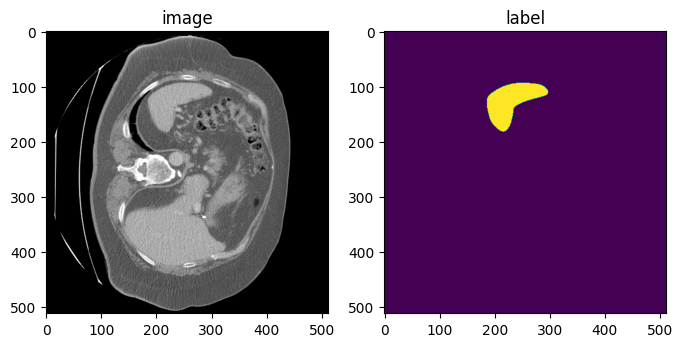

In [146]:
image, label = data_scale["image"], data_scale["label"]
print("after scaled: large difference")
plt.figure("visualize", (8, 4))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[0,:, :, 30], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0,:, :, 30])
plt.show()

* 空间变换 [Rotate90d / Resized]\
Rotate90d：输入数组在由space_axes指定的平面中旋转90度\
参 数 介 绍\
prob:  float, 旋转的概率，默认为0.1， 也就是10%的概率被旋转\
max_k: int, 旋转90度的次数，默认为3\
spatial_axes: 元祖（int，int)。指定围绕哪个面旋转，默认为（0，1），即按前两个轴旋转。\
    * 注意注意 使用旋转，尤其是随机旋转的时候一定要注意，如果是分割，image和label应当一同旋转，并且旋转方式要一模一样。​​​​​​

In [ ]:
from monai.transforms import RandRotate90d, Resized
rotate = RandRotate90d(keys=['image', 'label'], prob=1, max_k=1, spatial_axes=(0,1))
data_rotate = rotate(data_scale)

print('original shape',data_scale['image'].shape)
print('rotated shape',data_rotate['image'].shape)

image, label = data_rotate["image"], data_rotate["label"]
print("after rotated:")
plt.figure("visualize", (8, 4))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[0,:, :, 30], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0,:, :, 30])
plt.show()

* Resized\
参 数 介 绍\
spatial_size: 序列[int, int,] 大小调整操作之后的空间尺寸的形状\
mode: resize使用的插值方式，默认为”area, “可以选择"nearest", "linear", "bilinear", "bicubic", "trilinear"


before rotated (1, 512, 512, 55)
after rotated (1, 256, 256, 60)
after resized:


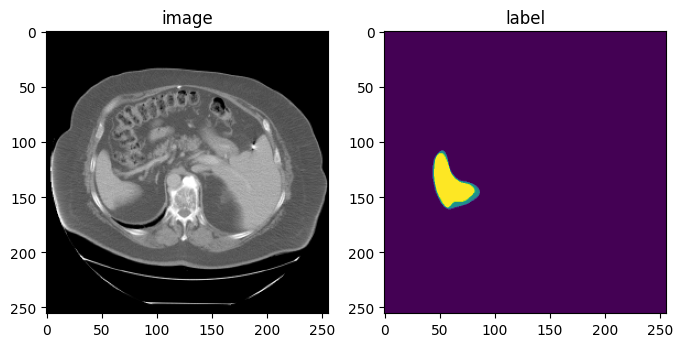

In [119]:
resize = Resized(keys=['image', 'label'], spatial_size=(256,256,60))
data_resize = resize(data_rotate)
print('before rotated',data_rotate['image'].shape)
print('after rotated',data_resize['image'].shape)

image, label = data_resize["image"], data_resize["label"]
print("after resized:")
plt.figure("visualize", (8, 4))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[0,:, :, 30], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0,:, :, 30])
plt.show()

# 裁剪&填充
SpatialCropd, CenterSpatialCropd, CropForegroundd, RandCropByPosNegLabeld, SpatialPad\
对于CT或者MRI图像来讲，图像是非常大的，又是一个三维图像，不可能全部输入网络中训练。要么把图像直接Resize到固定的尺寸，要么就是裁剪图像。monai提供了非常多的裁剪模式，包括中心裁剪，前景裁剪和随机裁剪等等，同时图像不够大的话，也可以进行填充。今天介绍几种经常用到的裁剪方式。\
注意事项，这些裁剪方式都要求数据格式为通道优先格式（必须有通道维度），也就是说要放在Addchanneld后面使用

## SpatialCropd： 空间裁剪

    这个函数是根据提供的空间中心和大小裁剪图像，如果未提供中心和大小，则必须提供ROI的开始和结束坐标来裁剪图像。

### 参 数 介 绍

    roi_center: int, ROI的中心体素坐标，如果是二维图像，则坐标是（x, y）, 如果是三维，则坐标是（x, y, z）

    roi_size: int, ROI的大小。很好理解，有了中心，再加上大小就可以裁减ROI了

    roi_start / roi_end, int,  如果不提供上述两个参数，还可以自己指定ROI的开始结束坐标

(1, 512, 512, 55)
(1, 256, 256, 31)
after:


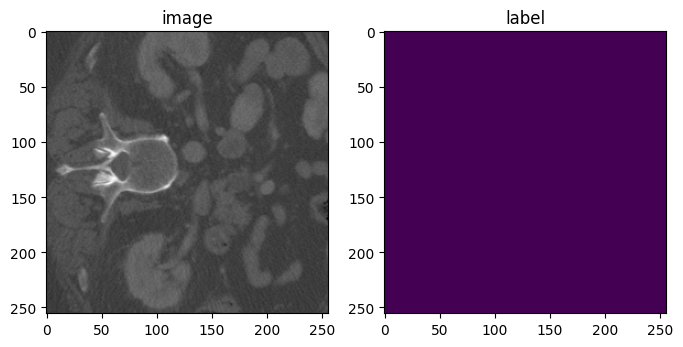

In [118]:
from monai.transforms import SpatialCropD, CenterSpatialCropd, CropForegroundd, RandCropByPosNegLabeld,SpatialPadD
 
loader = LoadImaged(keys=["image", "label"], dtype=np.float32)
add_channel = AddChanneld(keys=["image", "label"])
# 重新加载一个图像
 
data_dict = loader(train_data_dicts[0])
datac_dict = add_channel(data_dict)   # (1, 512, 512, 61)
 
crop0 = SpatialCropD(keys=["image", "label"], roi_center=(256,256,31), roi_size=(256,256,31))
# 中心坐标为图像的中点(256,256,30)， 大小也是(256,256,30)
data_crop = crop0(datac_dict)
print(datac_dict['image'].shape)
print(data_crop['image'].shape) # (1, 256, 256, 30)     

image, label = data_crop["image"], data_crop["label"]
print("after:")
plt.figure("visualize", (8, 4))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[0,:, :, 0], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0,:, :, 0])
plt.show()

按中心裁是裁不到脾脏的，于是我们可以手动输入起始点坐标，这样就裁剪到目标了。

其实后面的各种裁剪都是会在内部调用SpatialCropd的，只是坐标的获取方式不一样。

after:


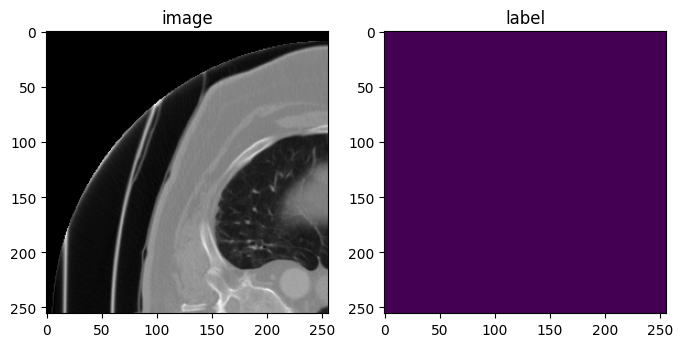

In [120]:
crop1 = SpatialCropD(keys=["image", "label"], roi_start=(0,0,40), roi_end=(256,256,60))
data_crop = crop1(datac_dict)
data_crop['image'].shape  # (1, 256, 256, 20)  
image, label = data_crop["image"], data_crop["label"]
print("after:")
plt.figure("visualize", (8, 4))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[0,:, :, 0], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0,:, :, 0])
plt.show()

## CenterSpatialCropd： 中心裁剪
这个裁剪方式就非常简单了，看参数只需要提供ROI大小，自动给你中心裁剪，而不需要像SpatialCropd一下手动提供中心坐标。

(1, 256, 256, 30)
after:


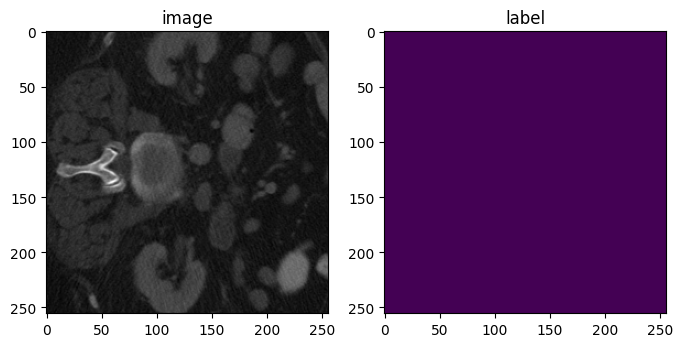

In [117]:
crop2 = CenterSpatialCropd(keys=['image', 'label'], roi_size=(256,256,30))
data_crop = crop2(datac_dict)
print(data_crop['image'].shape)  # (1, 256, 256, 30)

image, label = data_crop["image"], data_crop["label"]
print("after:")
plt.figure("visualize", (8, 4))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[0,:, :, 0], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0,:, :, 0])
plt.show()

## CropForegroundd： 裁剪前景

    使用边框裁剪图像。通过在使用select_fn选择前景来生成边界框。在边框的每个空间尺寸中添加边距。如果整个医学图像中的有效部分很小，通常用于帮助训练和验证。

    简单讲，可以自己定义裁剪的方式，比如按图像值>0的裁剪，按 label 中>0的裁剪等等。反正找出图像中有效的部分用于训练。

    注意：CropForegroundd和CropForeground会有些区别，CropForeground不会有label，所以不可能按label的值去选择图像。所以分割的话，建议用字典形式，就可以裁剪出有阳性值的部分。

    参 数 介 绍

    source_key： str,  按image还是label裁剪图像.这里的key, 就是keys=['image', 'label']中的key。

    select_fn: 按照什么原则选择前景。默认为选择大于0的值作为前景。比如，如果source_key="image", 则选择的是image>0的部分作为前景

    channel_indices: 选择特定的通道

    margin: int, 边缘填充的个数。通常用原来的值进行填充。默认为0，则不填充。

    start_coord_key：str,  记录前景空间边界框的起始坐标的键(不了解)。

    end_coord_key：str，记录前景空间边界框的结束坐标的键(不了解)。

### 举例1 首先是一个用普通模式的小例子

    可以发现他是保留整个涵盖满足条件像素的方框区域，所以有一部分的0也会留存下来

tensor([[[1, 2, 1, 0],
         [1, 3, 2, 1],
         [1, 2, 1, 0]]], dtype=torch.int32)


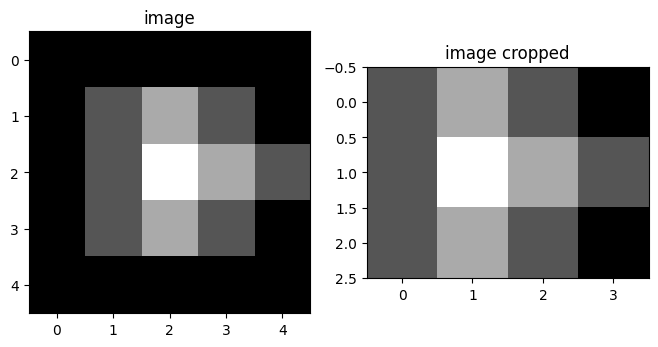

In [141]:
from monai.transforms import CropForeground
Example1 = np.array(
    [[[0, 0, 0, 0, 0],
      [0, 1, 2, 1, 0],
      [0, 1, 3, 2, 1],
      [0, 1, 2, 1, 0],
      [0, 0, 0, 0, 0]]])  # 1x5x5, single channel 5x5 image
cropper = CropForeground(select_fn=lambda x: x >= 1, margin=0, return_coords=False)
print(cropper(Example1))

plt.figure("visualize", (8, 4))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(Example1[0,:,:], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("image cropped")
plt.imshow(cropper(Example1)[0,:,:], cmap="gray")
plt.show()

### 举例2  裁剪image中大于300的像素点，边缘扩充2个像素点

(1, 475, 397, 55)
after:


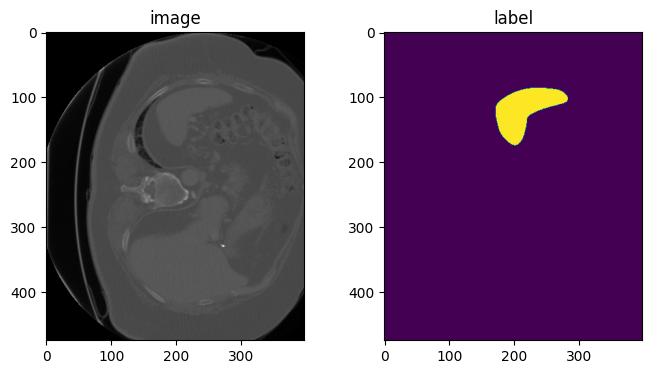

In [148]:
crop3 = CropForegroundd(keys=['image', 'label'], source_key='image', select_fn=lambda x: x > 300, margin=0)
# 裁剪原则为： image中大于300的像素点，边缘扩充2个像素点
data_crop = crop3(datac_dict)
print(data_crop['image'].shape)
image, label = data_crop["image"], data_crop["label"]
print("after:")
plt.figure("visualize", (8, 4))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[0,:, :, 30], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0,:, :, 30])
plt.show()

### 举例3  裁剪label中大于0的像素点，并扩充2个像素点

    可以看出，使用了label来裁剪图像，可以精准定位目标。

(1, 111, 117, 21)
after:


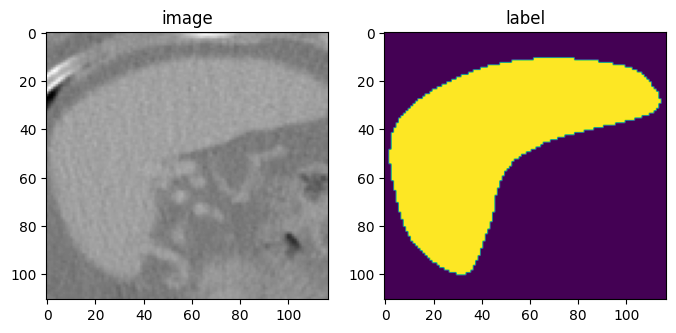

In [155]:
crop3 = CropForegroundd(keys=['image', 'label'], source_key='label', select_fn=lambda x: x > 0, margin=2)
# 裁剪原则为： label中大于0的像素点，边缘扩充2个像素点
data_crop = crop3(datac_dict)
print(data_crop['image'].shape)  # (1, 124, 105, 15)
image, label = data_crop["image"], data_crop["label"]
print("after:")
plt.figure("visualize", (8, 4))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[0,:, :, 10], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0,:, :, 10])
plt.show()

## RandCropByPosNegLabeld： 按阴性阳性比裁剪\
    如果你一幅图像很大，需要裁剪成多个子图，那这个方法就再合适不过了。像是腹部CT这种很大的三维图像，我通常都会使用这个方法，按照阴性阳性比裁剪成4个子图。
    
    从图中可以看出，通过label来裁剪图像，设置阴阳比1:1时，一半图像包含label，一半不包含，每幅图像的差异不是很大。想要阳性更多，加大阳性的比例，想要阴性更多，加大阴性的比例。

### 参 数 介 绍

    label_key: str, 又是一个需要提供key的参数。代表label的键（我们的例子中就是"label"），用于查找前景和背景

    spatial_size: [int, int], ROI的大小

    pos: float, 与neg一起用于计算将前景体素而不是背景体素选为中心的概率的比率. 选中阳性值的概率为：pos / (pos + neg)

    neg: float, 与pos同理。

    num_samples: int, 返回多少个子图

    image_key: str, 如果提供了image key， 就会使用label==0, 并且image>image_threshold (阈值)的部分作为阴性样本，所以裁剪中心将仅存在于有效图像区域上。

    image_threshold: float, 如果使用了image_key， 则提供阈值

    fd_indices_key: str, 根据提供的前景索引来裁剪图像，将忽略image_key和 image_threshold

    bg_indices_key：str,  需要同fd_indices_key一起提供。典型的是通过FgBgToIndicesd获取索引并缓存结果。

    举例  从原图像中裁剪4个大小为(256,256,30)的子图，并且阳性比率为1/2


In [162]:
print(datac_dict['image'].shape)

(1, 512, 512, 55)


the orig. image shape is  {(1, 512, 512, 55)}
there are 4 croped images
the croped image shape is  {(1, 256, 256, 1)}


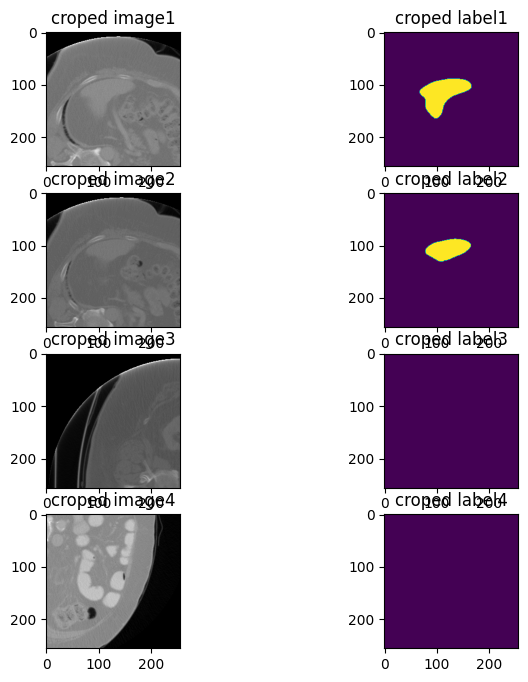

In [190]:
crop4 = RandCropByPosNegLabeld(keys=["image", "label"], label_key='label', spatial_size=(256,256,1),
                              pos=1.0, neg=1.0, num_samples=4, image_key='image', image_threshold=200.0)
data_crop = crop4(datac_dict)

print('the orig. image shape is ', {datac_dict['image'].shape})
print(f'there are {len(data_crop)} croped images')
print('the croped image shape is ', {data_crop[0]['image'].shape}) # 这里返回了4幅图像，所以需要索引

imagecrop1, labelcrop1 = data_crop[0]['image'][0], data_crop[0]['label'][0]
imagecrop2, labelcrop2 = data_crop[1]['image'][0], data_crop[1]['label'][0]
imagecrop3, labelcrop3 = data_crop[2]['image'][0], data_crop[2]['label'][0]
imagecrop4, labelcrop4 = data_crop[3]['image'][0], data_crop[3]['label'][0]


plt.figure("visualize", (8, 8))
plt.subplot(4, 2, 1)
plt.title("croped image1")
plt.imshow(imagecrop1[:, :, 0], cmap="gray")
plt.subplot(4, 2, 2)
plt.title("croped label1")
plt.imshow(labelcrop1[:, :, 0])
plt.subplot(4, 2, 3)
plt.title("croped image2")
plt.imshow(imagecrop2[:, :, 0], cmap="gray")
plt.subplot(4, 2, 4)
plt.title("croped label2")
plt.imshow(labelcrop2[:, :, 0])

plt.subplot(4, 2, 5)
plt.title("croped image3")
plt.imshow(imagecrop3[:, :, 0], cmap="gray")
plt.subplot(4, 2, 6)
plt.title("croped label3")
plt.imshow(labelcrop3[:, :, 0])
plt.subplot(4, 2, 7)
plt.title("croped image4")
plt.imshow(imagecrop4[:, :, 0], cmap="gray")
plt.subplot(4, 2, 8)
plt.title("croped label4")
plt.imshow(labelcrop4[:, :, 0])
plt.show()

## SpatialPadd： 空间填充

    裁剪已经学了很多种了，有时还是需要用到填充的。

### 参 数 介 绍

    spatial_size: [int, int], 填充后的空间大小

    method: str, 填充的方法， 有两种。"symmetric"(对称填充)（默认方式）， "end"(仅在末端填充)

    mode: str， 填充值的获取方式，如"constant"（填充0, "edge"(用边缘值填充)， "maximum "(最大值填充)

    举例  填充值=0

(1, 512, 512, 1)
tensor(0.)


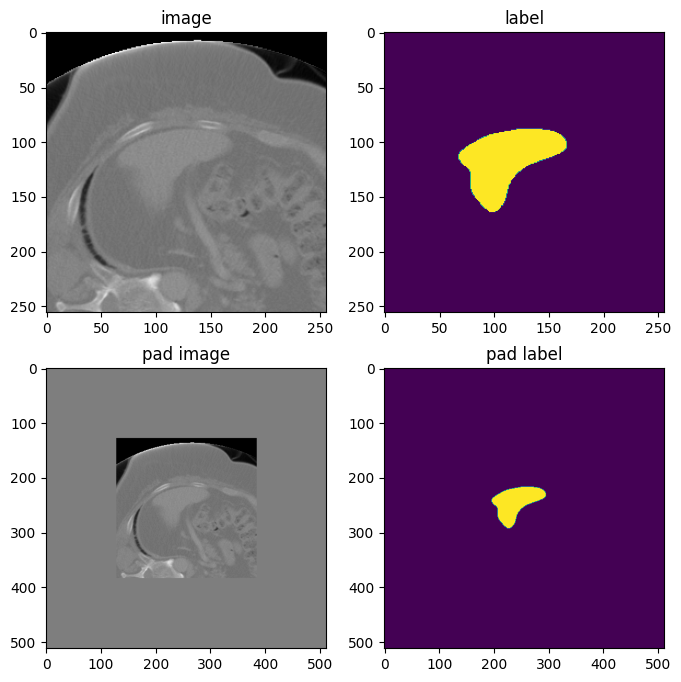

In [195]:
pad = SpatialPadD(keys=["image", "label"], spatial_size=(512,512,1), method='symmetric', mode='constant')
 
data_orig=data_crop[0]
data_pad = pad(data_orig)   # 把刚才裁剪的图像放大
 
print(data_pad['image'].shape)  # (1, 512, 512, 60)
print(data_pad['image'][0,0,0,0])   # 填充的是0

image, label = data_orig["image"][0], data_orig["label"][0]
imagepad, labelpad = data_pad["image"][0], data_pad["label"][0]
plt.figure("visualize", (8, 8))
plt.subplot(2, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 0], cmap="gray")
plt.subplot(2, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 0])
plt.subplot(2, 2, 3)
plt.title("pad image")
plt.imshow(imagepad[:, :, 0], cmap="gray")
plt.subplot(2, 2, 4)
plt.title("pad label")
plt.imshow(labelpad[:, :, 0])
plt.show()

注意，填充的0在这里是灰色而不是黑色，因为黑色的值是比0还小的。

* 举例 边缘填充